# Permutation feature importance for classifying heart beats using a multi-layer perceptron

In [26]:
import numpy as np
import pickle
import glob
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import os
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn import *
from sklearn.metrics import *
from sklearn.model_selection import StratifiedKFold
sns.set()
import warnings
warnings.filterwarnings("ignore")
length = 277

### Load the holdout beats data and one-hot encode the heart beat classes

In [30]:
# Load the training and testing data:
train_values = np.empty(shape=[0, length])
test_values = np.empty(shape=[0, length])

train_beats = glob.glob('../../train_beats.csv')
test_beats = glob.glob('../../test_beats.csv')

for j in train_beats:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    train_values = np.append(train_values, csvrows, axis=0)

for j in test_beats:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    test_values = np.append(test_values, csvrows, axis=0)
    
print(train_values.shape)
print(test_values.shape)

# Separate the training and testing data, and one-hot encode Y:
X_train = train_values[:,:-2]
X_test = test_values[:,:-2]
y_train = train_values[:,-2]
y_test = test_values[:,-2]

# Combine everything again:
X = np.concatenate((X_train, X_test), axis = 0)
Y = np.concatenate((y_train, y_test), axis = 0)

# One-hot encode Y:
Y = to_categorical(Y)

Loading  ../../train_beats.csv
Loading  ../../test_beats.csv
(31912, 277)
(37863, 277)


### Build the multi-layer perceptron architecture

In [32]:
# Build a multi-layer perceptron:
def getModel():
    mlpmodel = Sequential()
    mlpmodel.add(Dense(100, activation = 'relu'))
    mlpmodel.add(Dense(9, activation = 'softmax'))
    return mlpmodel

In [37]:
mlpmodel.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 100)               27600     
_________________________________________________________________
dense_9 (Dense)              (None, 9)                 909       
Total params: 28,509
Trainable params: 28,509
Non-trainable params: 0
_________________________________________________________________


### Implement and apply permutation feature importance for the multi-layer perceptron

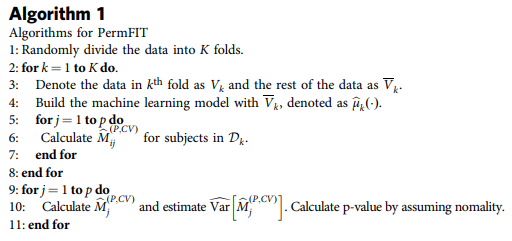

In [16]:
from IPython.display import Image
Image("../../algorithm_permutation_feature_importance.png")

__Perturbation methods:__ <br>
There are different types of perturbation possible for permutation feature importance, such as mean perturbation, zero perturbation, and random perturbation. They are shown in the plot below. In the implementation in this notebook, the data points within one slice are randomly shuffled. 

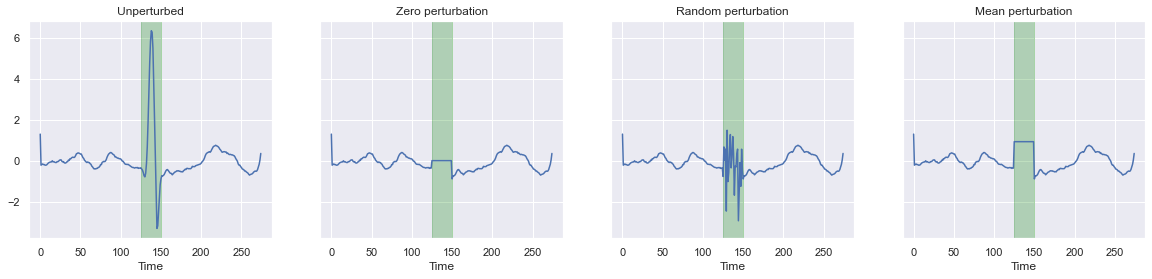

In [20]:
fig, ax = plt.subplots(1, 4, figsize = (20, 4), sharex = True, sharey=True)

# Unperturbed: the original signal.
ax[0].set_title('Unperturbed')
ax[0].plot(np.arange(len( X[20, :])), X[20, :])

# Zero perturbation: the values within the current slice are set to zero.
ax[1].set_title('Zero perturbation')
X_zero_perturbed = X[20, :].copy()
X_zero_perturbed[5 * 25 : 6 * 25] = 0.0
ax[1].plot(np.arange(len(X[20, :])), X_zero_perturbed)

# Random perturbation: the values within the current slice are replaced with random numbers.
ax[2].set_title('Random perturbation')
X_random_perturbed = X[20, :].copy()
X_random_perturbed[5 * 25 : 6 * 25] = np.std(X[20, :]) * np.random.randn(25) + np.mean(X[20, :])
ax[2].plot(np.arange(len(X[20, :])), X_random_perturbed)

# Mean perturbation: the values within the current slice are averaged.
ax[3].set_title('Mean perturbation')
X_mean_perturbed = X[20, :].copy()
X_mean_perturbed[5 * 25 : 6 * 25] = np.mean(X[20, 5 * 25 : 6 * 25])
ax[3].plot(np.arange(len(X[20, :])), X_mean_perturbed)

for i in range(4):
    ax[i].set_xlabel('Time')
    ax[i].axvspan(5 * 25, 6 * 25, color = 'green', alpha = 0.25)
fig.savefig('perturbation_methods_ecg_data.jpg', dpi = 400)

In [38]:
# Permutation feature importance:
skf = StratifiedKFold(n_splits = 5, shuffle = True)
fold_counter = 0
M = np.zeros((X.shape[0], 11))
for train_index, test_index in skf.split(X, np.argmax(Y, axis = 1)):
    print('Fold ', fold_counter)
    
    # Split the data in this fold:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    # Build the machine learning model with the training data:
    mlpmodel = getModel()
    mlpmodel.compile(optimizer = 'adam', loss = tf.keras.losses.CategoricalCrossentropy())
    mlpmodel.fit(X_train, y_train, epochs = 100, verbose = 0)
    
    # Predict on the test fold without permutations:
    pred_k = mlpmodel.predict(X_test)
    
    # For every feature:
    for slice_start in range(0, 275, 25):
        # Permute and predict:
        x_permuted = np.copy(X_test)
        x_slice = X_test[:, slice_start:slice_start+25]
        x_slice_permuted = np.random.permutation(x_slice)
        x_permuted[:, slice_start:slice_start + 25] = x_slice_permuted
        pred_perm = mlpmodel.predict(x_permuted)
        
        # Compute importance:
        importance = ((np.argmax(y_test, axis = 1) - np.argmax(pred_perm, axis = 1))**2 
                      - (np.argmax(y_test, axis = 1) - np.argmax(pred_k, axis = 1))**2)
        M[test_index, slice_start // 25] = importance 
    fold_counter += 1
mean_importance = np.mean(M, axis = 0)

Fold  0
Fold  1
Fold  2
Fold  3
Fold  4


In [ ]:
# Save the model so we can visualize it with Netron (https://github.com/lutzroeder/netron):
tf.keras.models.save_model(mlpmodel, 'mlpmodel_pfi_ecg.h5')

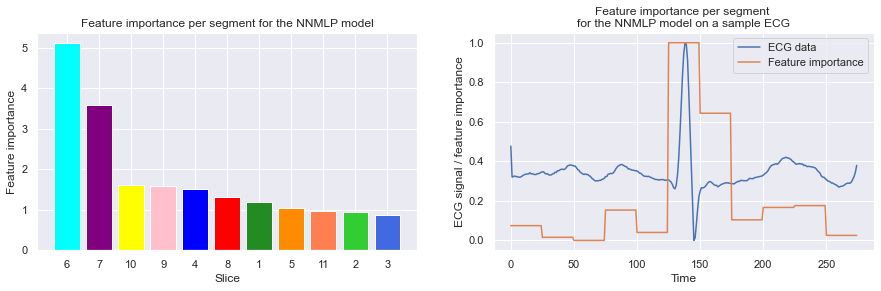

In [39]:
indices_sort = np.argsort(-1 * mean_importance)
slices = np.arange(1, 12)
colors = ['forestgreen', 'limegreen', 'royalblue', 'blue', 'darkorange', 'cyan', 'purple', 'red', 'pink', 'yellow', 'coral']

fig, ax = plt.subplots(1, 2, figsize = (15, 4))
ax[0].bar(range(11), mean_importance[indices_sort], color = np.array(colors)[indices_sort])
ax[0].set_title('Feature importance per segment for the NNMLP model')
ax[0].set_xticks(np.arange(11))
ax[0].set_xticklabels(slices[indices_sort].astype(int))
ax[0].set_xlabel('Slice')
ax[0].set_ylabel('Feature importance')

ecg_normalized = (X[20, :] - X[20, :].min()) / (X[20, :].max() - X[20, :].min())
feature_importance_normalized = (mean_importance - mean_importance.min()) / (mean_importance.max() - mean_importance.min())
ax[1].plot(np.arange(len(ecg_normalized)), ecg_normalized, label='ECG data')
ax[1].plot(np.repeat(feature_importance_normalized, 25), label = 'Feature importance')
ax[1].set_title('Feature importance per segment \nfor the NNMLP model on a sample ECG')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('ECG signal / feature importance')
ax[1].legend()
fig.savefig('MLP_permutation_feature_importance_result.jpg', dpi = 400)